In [29]:
import sys
import os
import time
import datetime
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
import seaborn as sn
from scipy import stats

from keras import backend as K
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

path_main_folder = '/home/antorosi/Documents/AutoEncoder'
path_sub_folder = '/home/antorosi/Documents/Prediction'

sys.path.append(path_main_folder)

from CVAE.cvae import compile_cvae, run_cvae
from CVAE.cvae_model import CVAE
from conso.load_shape_data import *  
from conso.conso_helpers import plot_latent_space_projection, pyplot_latent_space_projection_temp, pyplot_latent_space_projection_error

sys.path.append(path_sub_folder)
from aed.atypical_event import *
from aed.detection import get_atypical_score, sort_atypical_events
from aed.multi_period import get_prediction_results, get_aed_results, get_complete_df

### Load and shape data

In [5]:
# Load raw data
path_data = os.path.join(path_main_folder, 'data')
dict_data_conso = load_data_conso(path_data)

In [30]:
# Loading list
path_data = os.path.join("/local/home/antorosi/Documents/Prediction/data")
with open(os.path.join(path_data, 'ae_reference_list_wwe_2013-2017' + '.pickle'), 'rb') as f:
    ael_reference= pickle.load(f)

In [6]:
# Load Holiday day information
holiday_days_csv = os.path.join(path_data, "joursFeries.csv")
holiday_days_df = pd.read_csv(holiday_days_csv, sep=";")
holiday_days_df.ds = pd.to_datetime(holiday_days_df.ds)
holiday_days_df['is_hd'] = 1

In [7]:
# Unifomization
data_conso_df, dict_colnames_conso = get_uniformed_data_conso(dict_data_conso)

In [8]:
# Change ganularity ?
name_granu = '15m'
data_conso_df = change_granularity(data_conso_df, granularity="15min")

In [9]:
# Get x_conso dataframe for autoencoder purpose
x_conso = get_x_conso_autoencoder(data_conso_df, dict_colnames_conso)

### Model parameters

In [66]:
# model paths
path_models_folder = os.path.join(path_main_folder, 'out', 'cv_model_3')
name_dict_dataset = 'dict_datasets.pickle'
name_model = 'CVAE'

In [67]:
path_results = os.path.join(path_models_folder, 'results')
if not os.path.exists(path_results):
    os.mkdir(path_results)

In [68]:
# loading dataset
with open(os.path.join(path_models_folder, name_dict_dataset), 'rb') as f:
    dict_datasets = pickle.load(f)

In [69]:
cond_dim = dict_datasets['period_1']['dataset']['train']['x'][1].shape[1]
e_dims=[48,24,12]
d_dims=[12,24,48]
z_dim= 2
beta = 1

In [70]:
# Get folder for each model
list_file = os.listdir(path_models_folder)
list_model_folders = [el for el in list_file if el.startswith('period')]
list_model_folders = sorted(list_model_folders)

### Latent space projection

complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_true (InputLayer)             (None, 96)           0                                            
__________________________________________________________________________________________________
cond (InputLayer)               (None, 14)           0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 2), (None, 2 6856        x_true[0][0]                     
                                                                 cond[0][0]                       
__________________________________________________________________________________________________
sample_z (Lambda)               (None, 2)            0           encoder[1][0]              

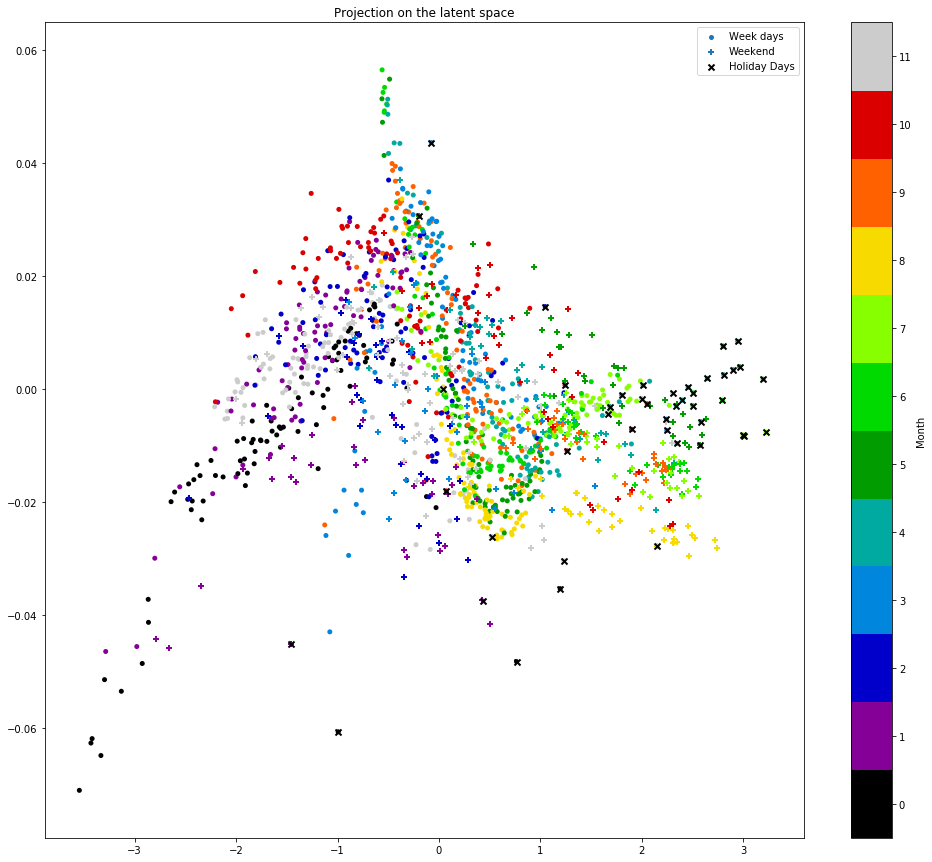

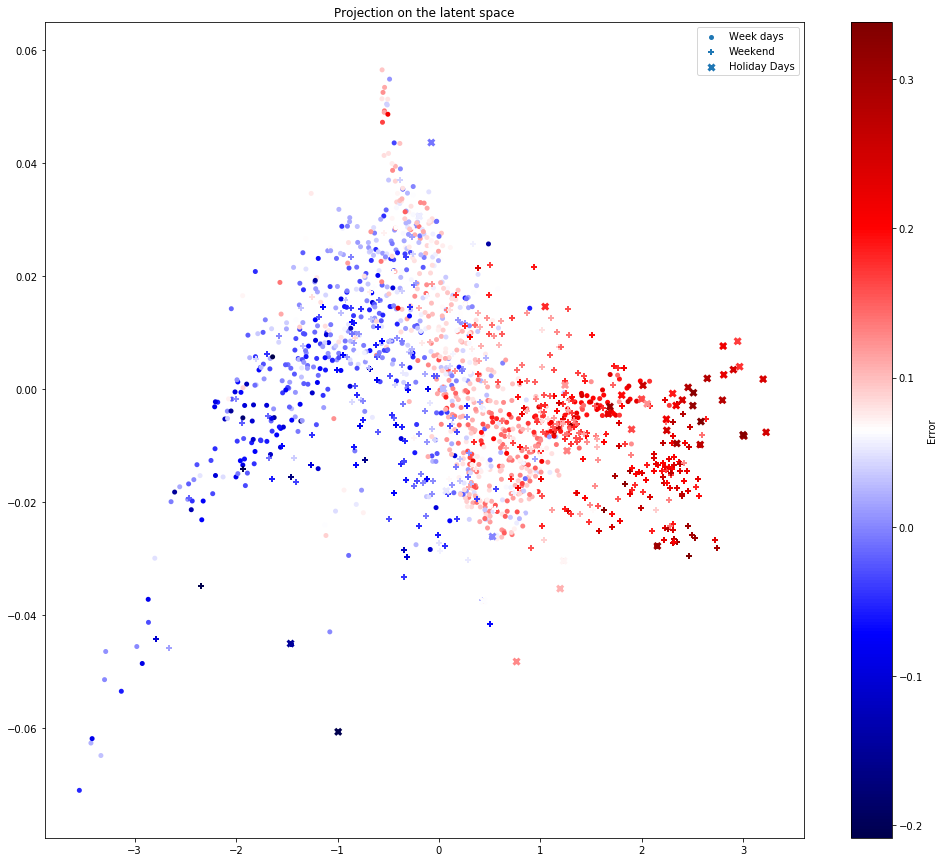

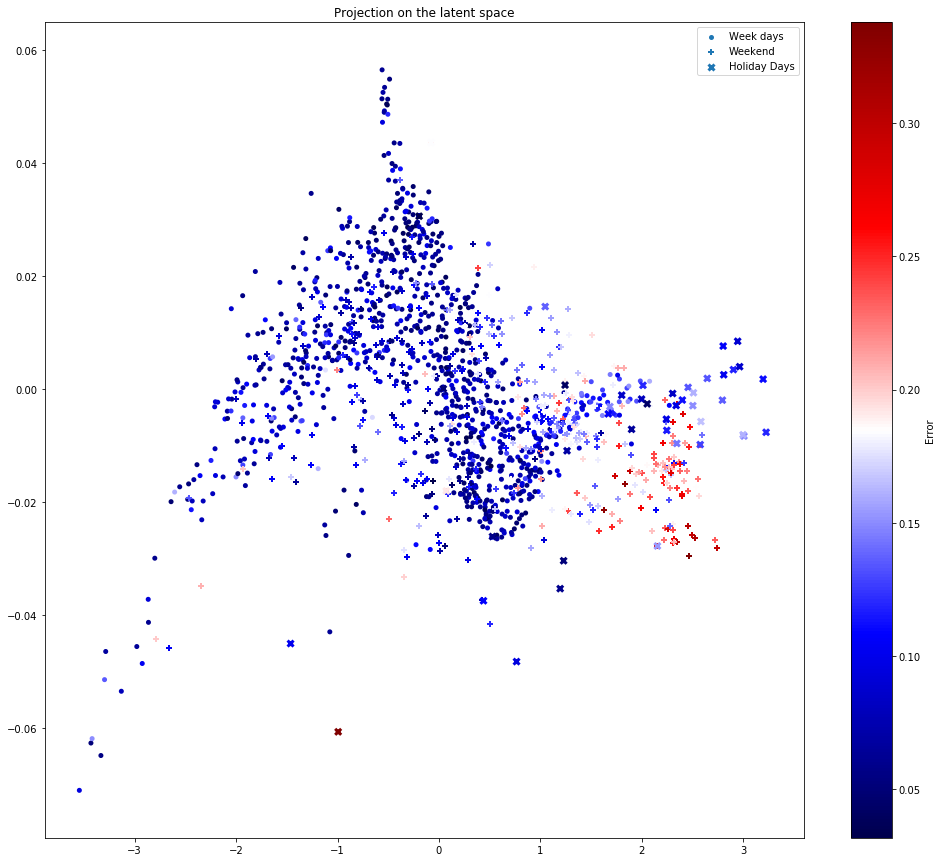

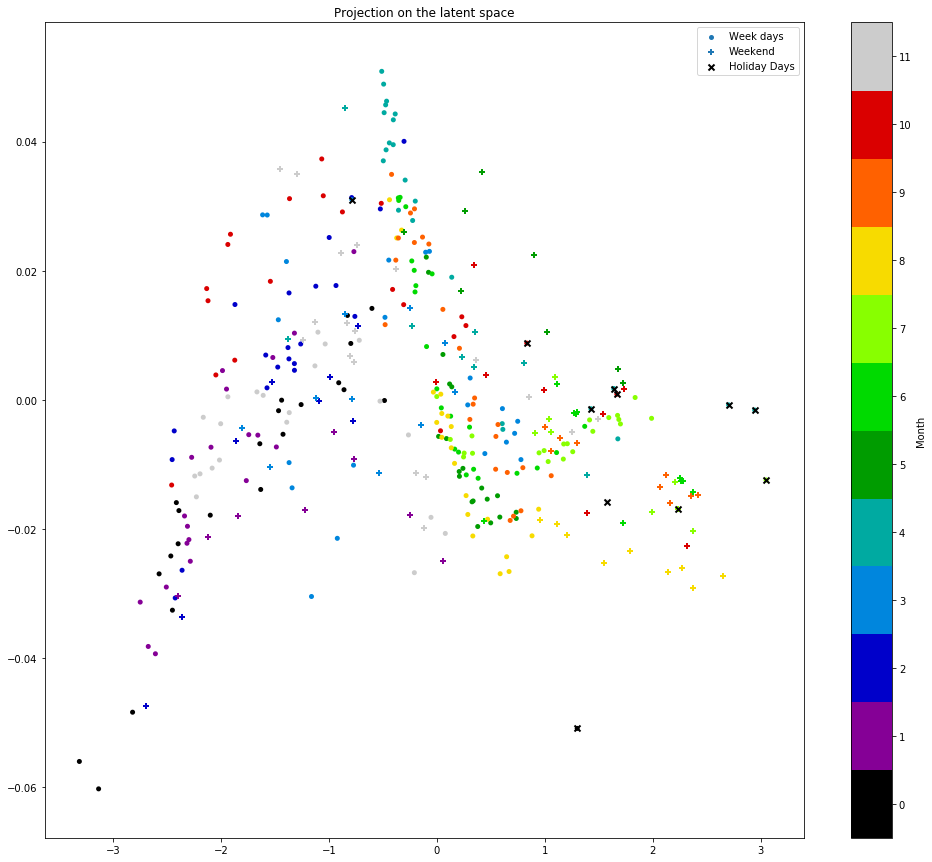

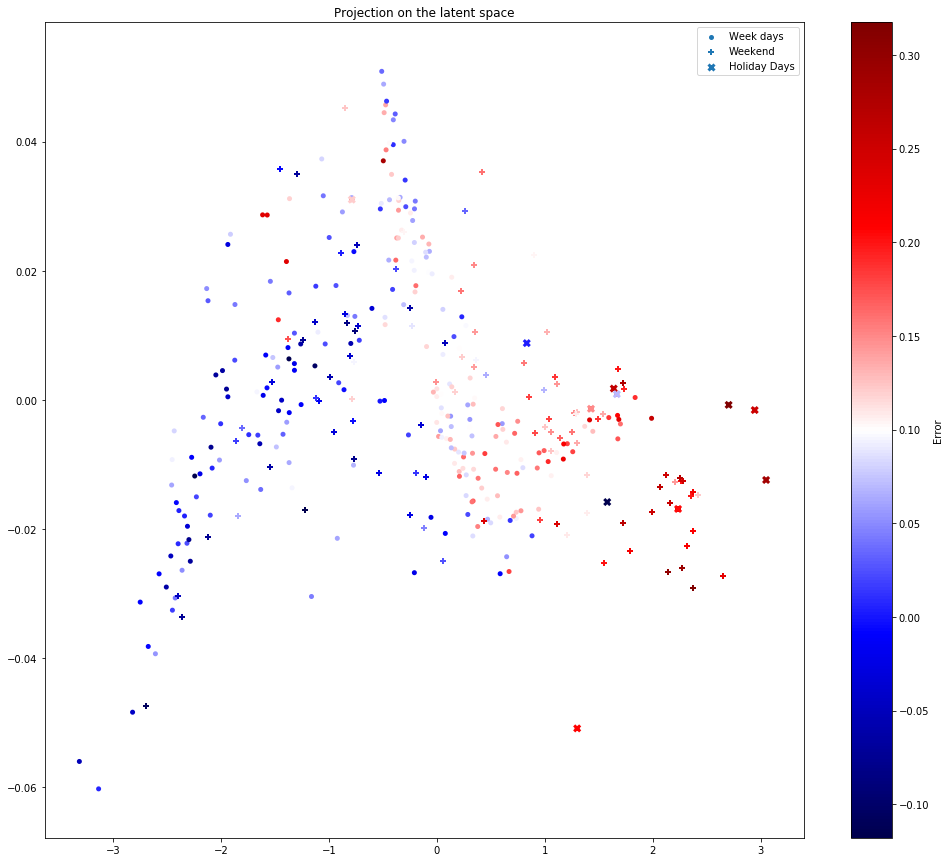

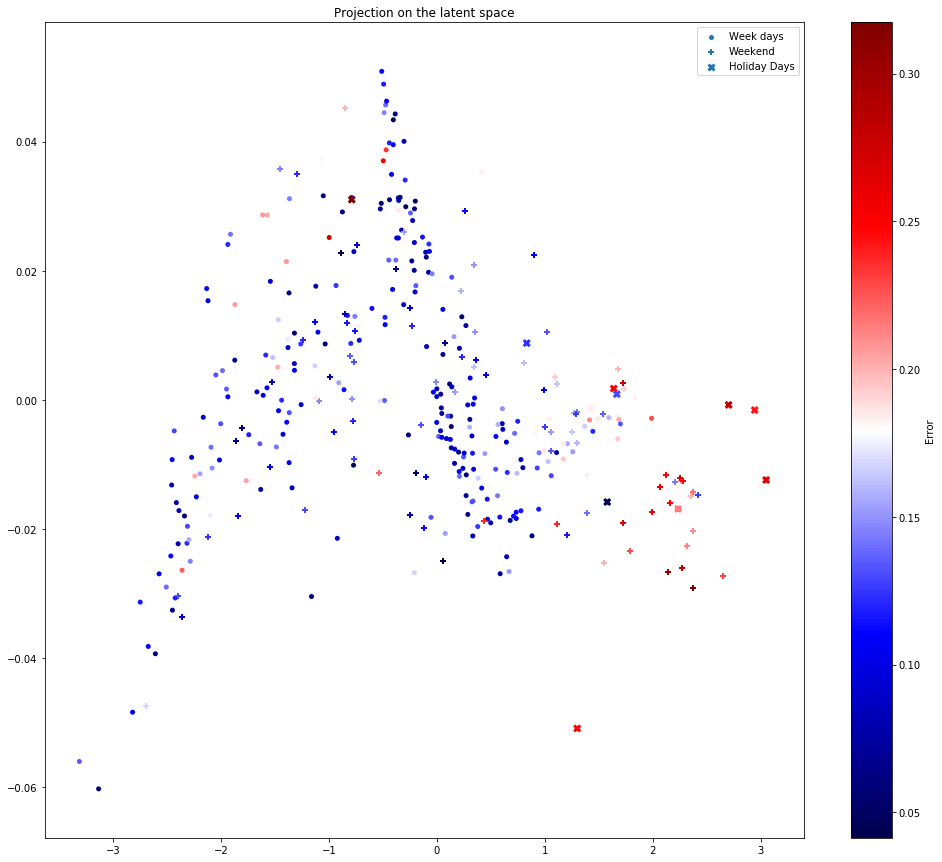

complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_true (InputLayer)             (None, 96)           0                                            
__________________________________________________________________________________________________
cond (InputLayer)               (None, 14)           0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 2), (None, 2 6856        x_true[0][0]                     
                                                                 cond[0][0]                       
__________________________________________________________________________________________________
sample_z (Lambda)               (None, 2)            0           encoder[1][0]              

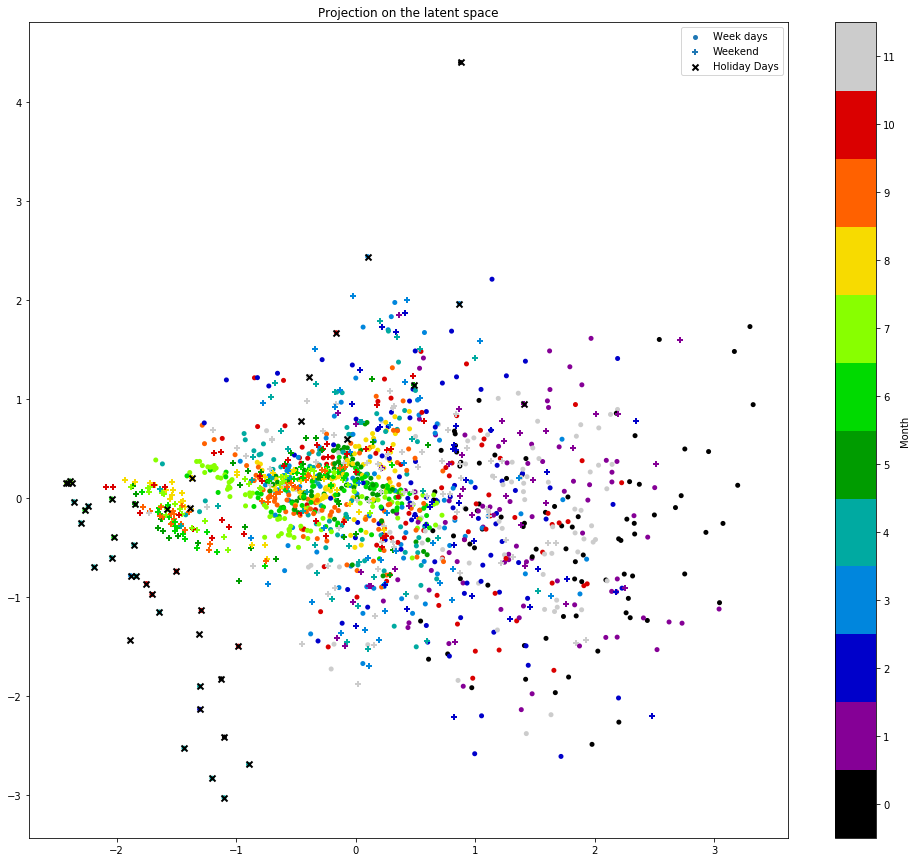

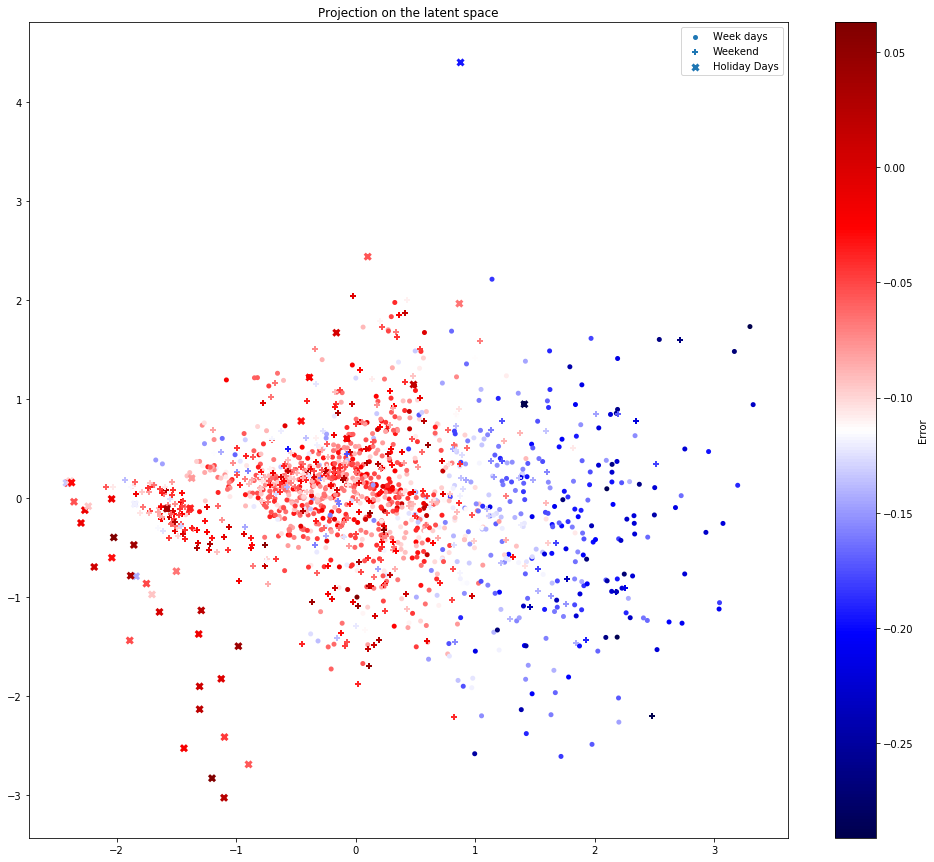

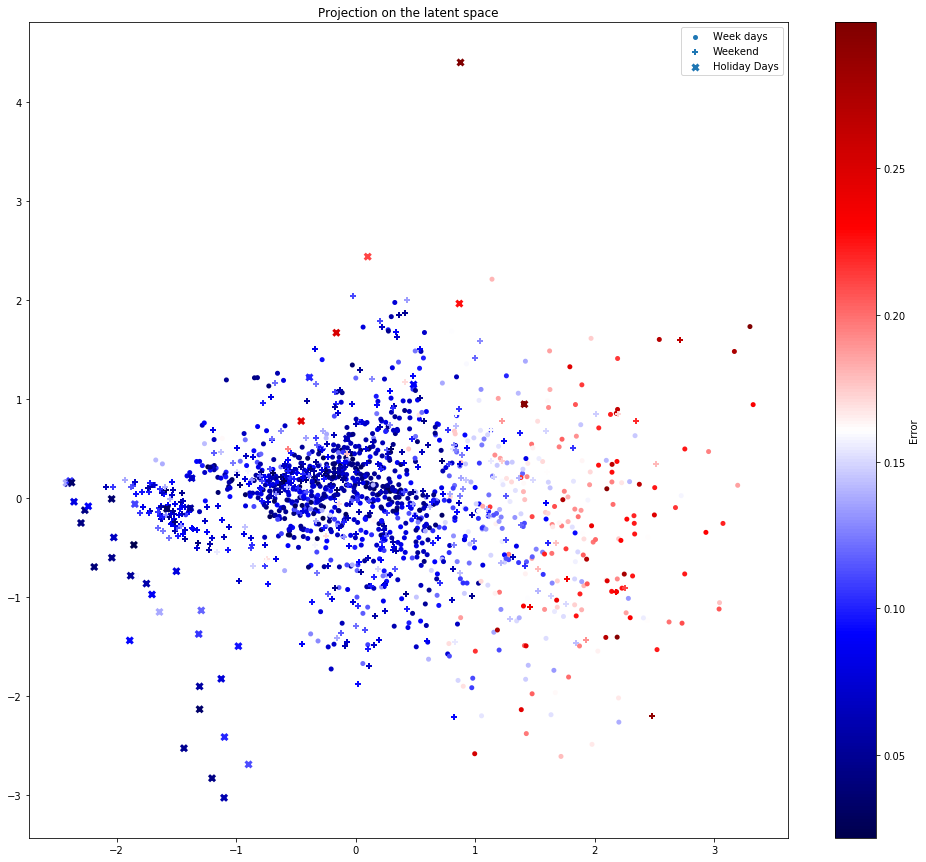

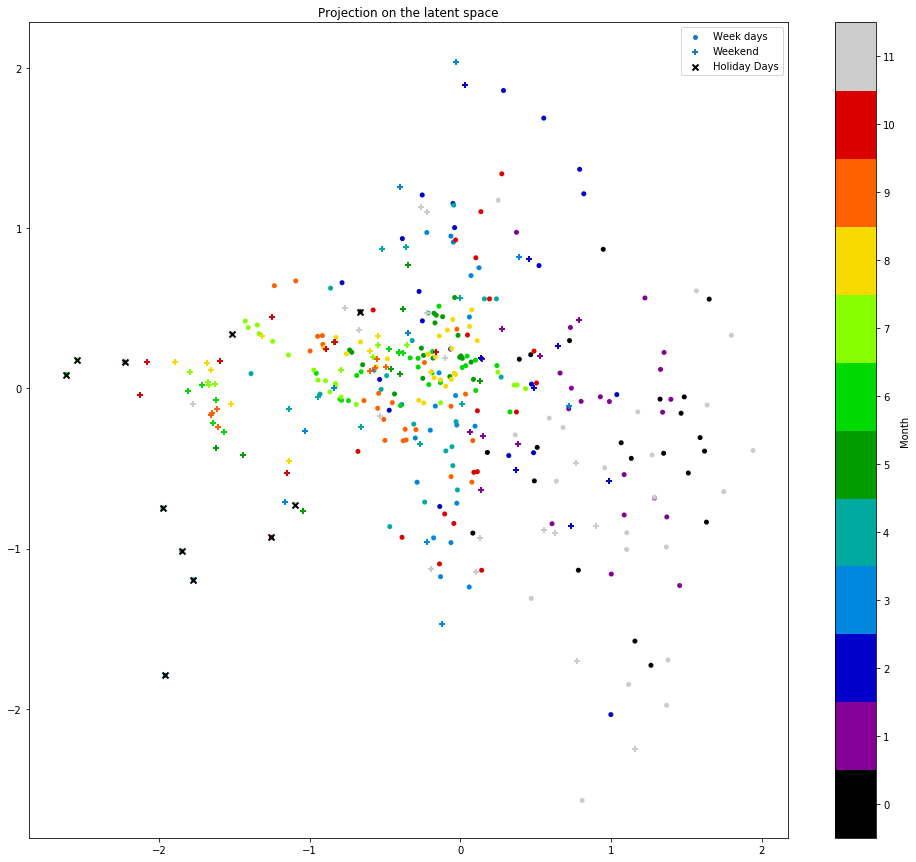

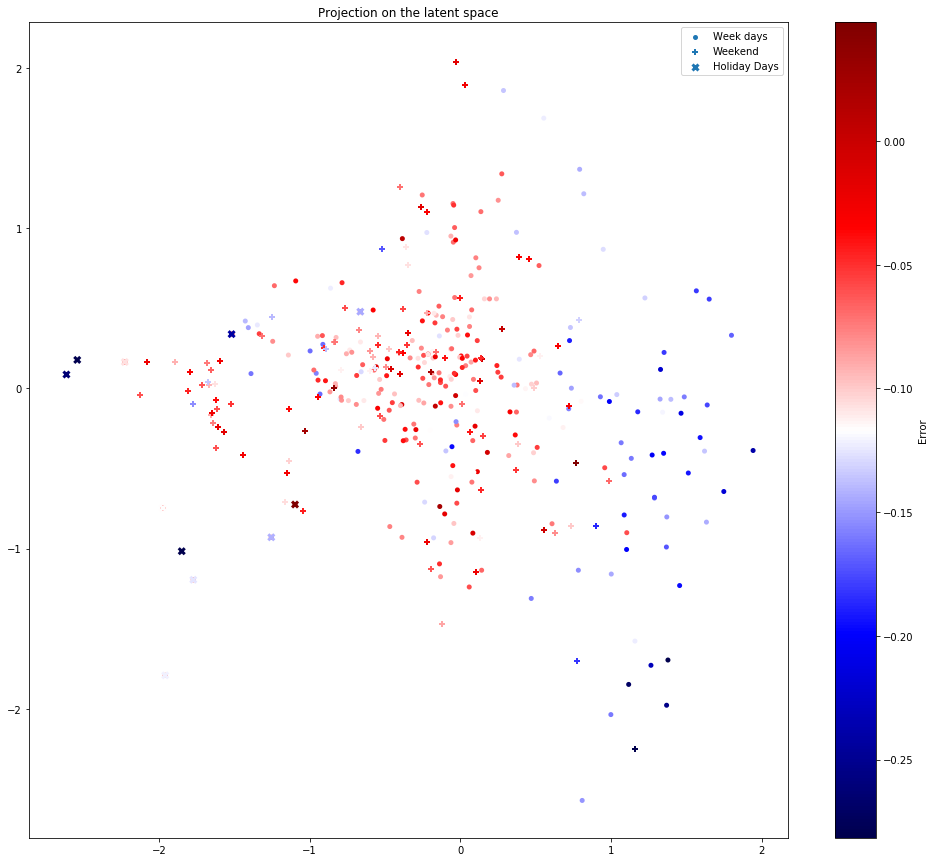

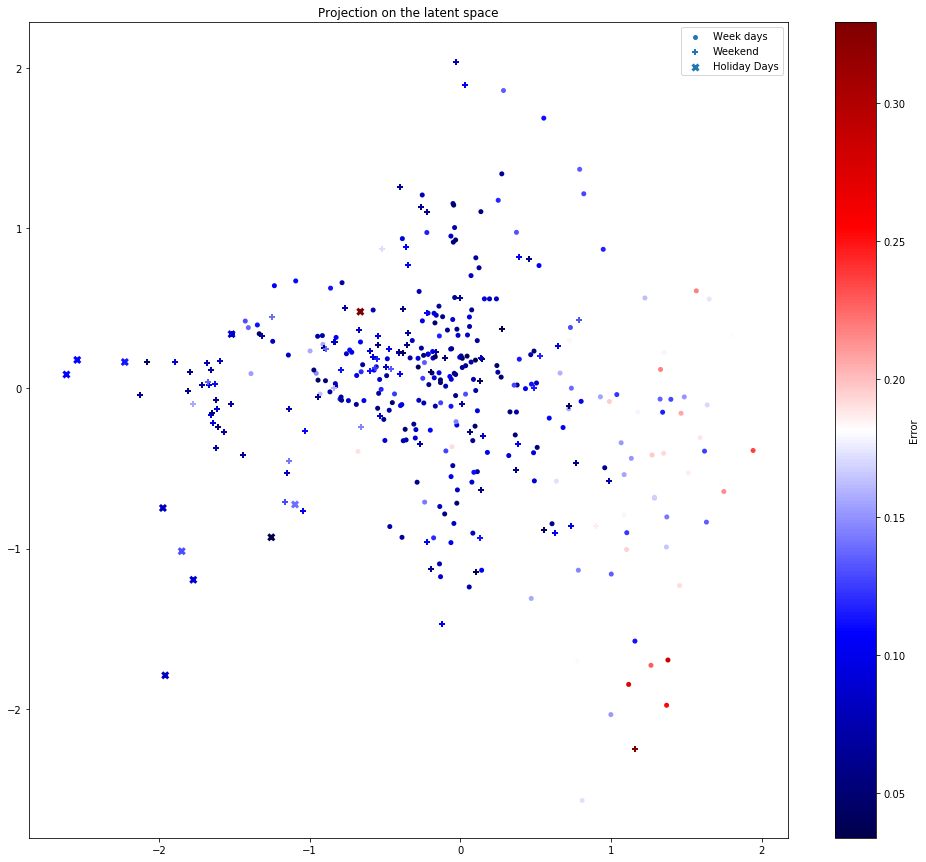

complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_true (InputLayer)             (None, 96)           0                                            
__________________________________________________________________________________________________
cond (InputLayer)               (None, 14)           0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 2), (None, 2 6856        x_true[0][0]                     
                                                                 cond[0][0]                       
__________________________________________________________________________________________________
sample_z (Lambda)               (None, 2)            0           encoder[1][0]              

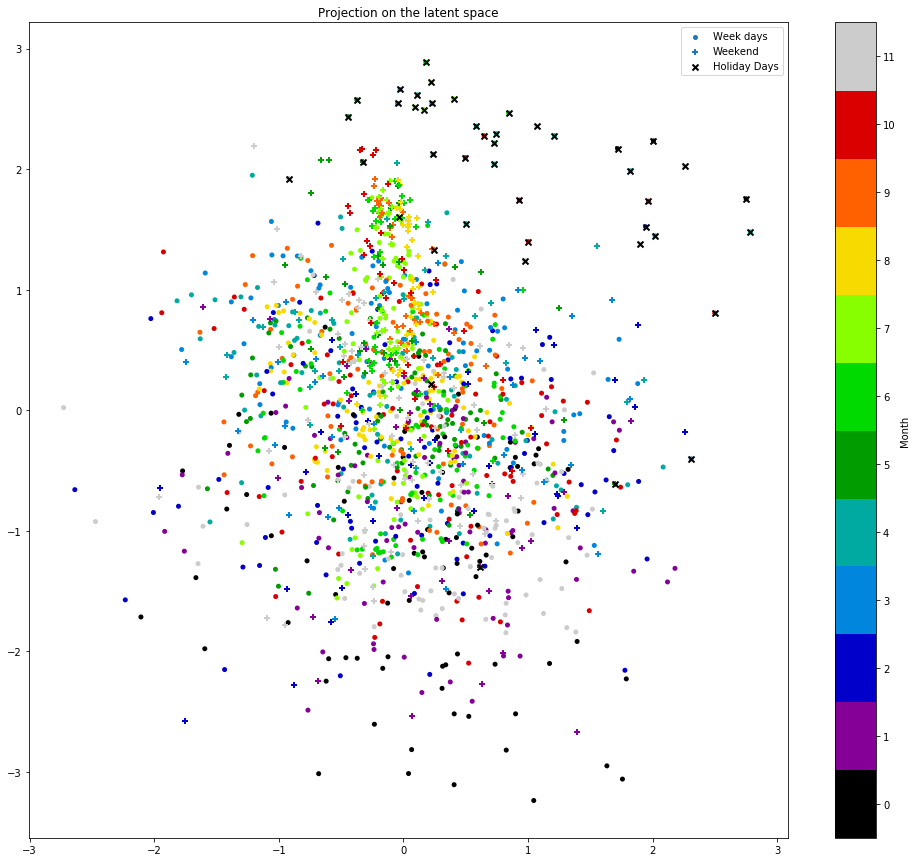

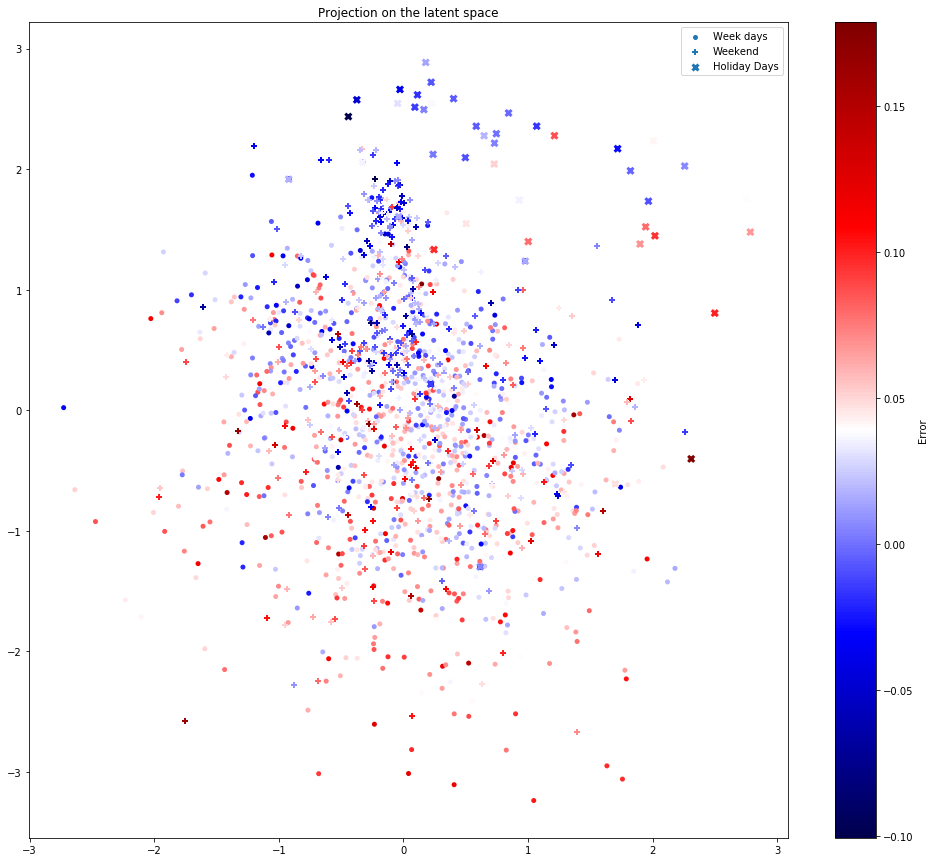

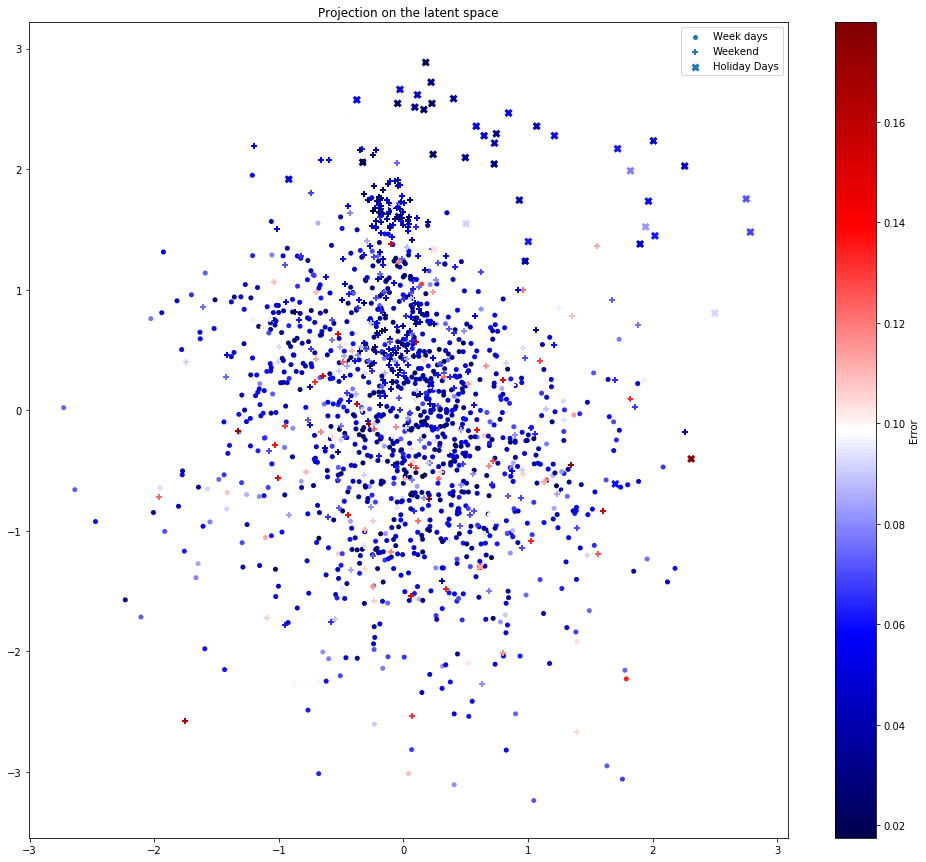

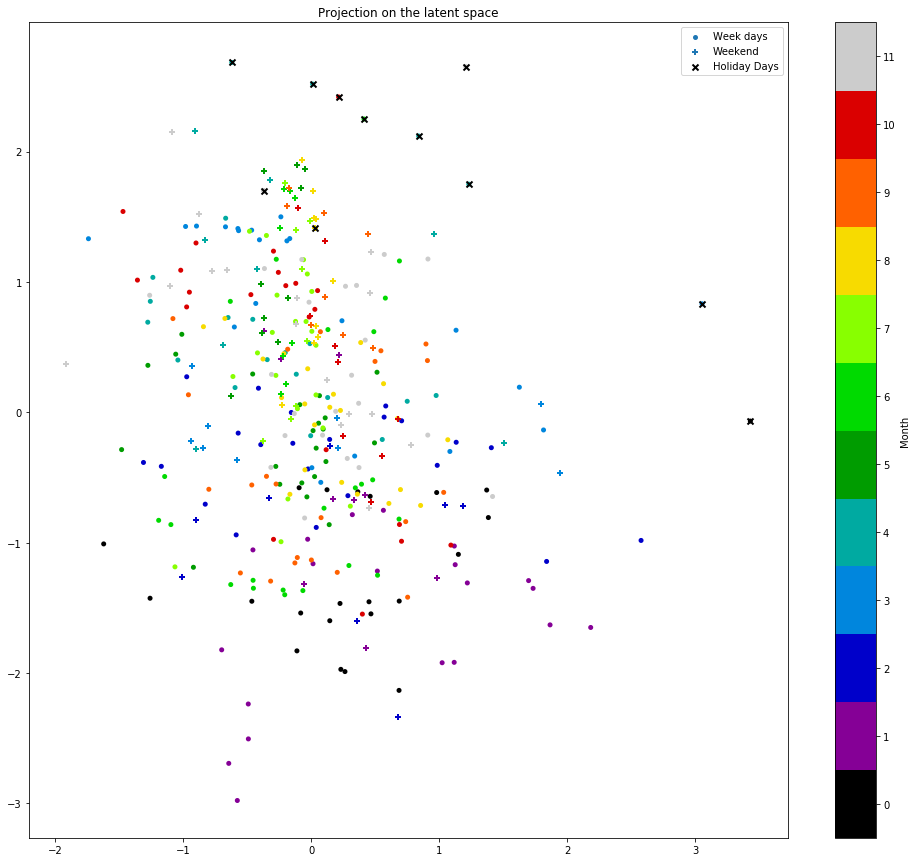

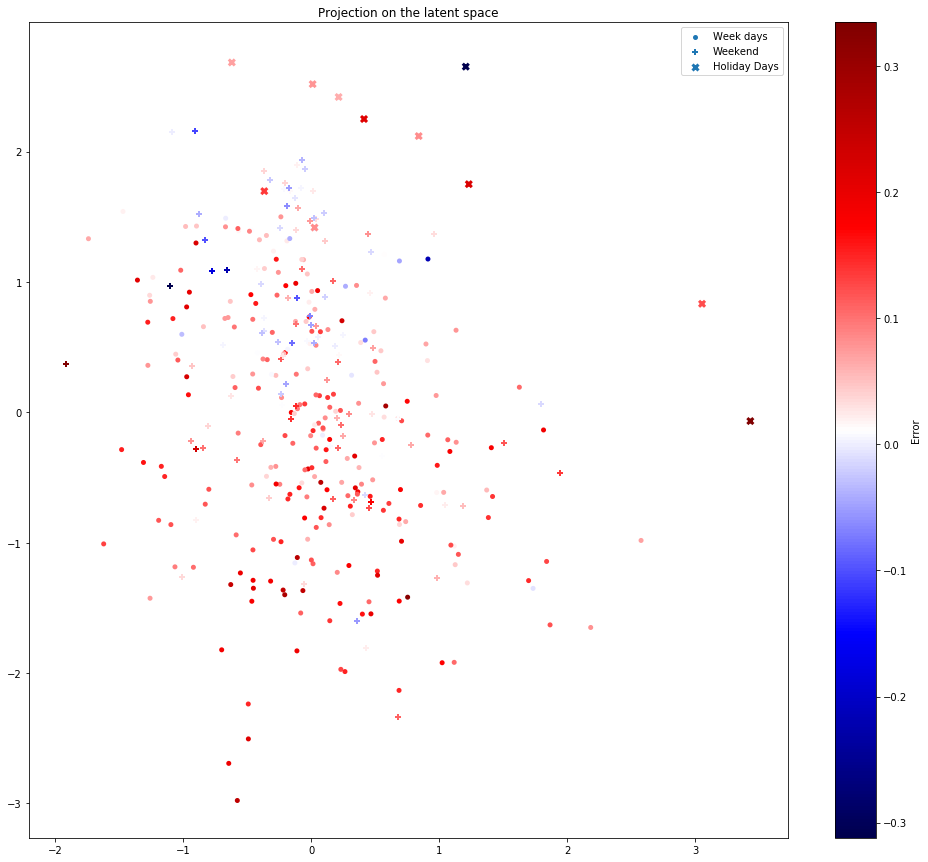

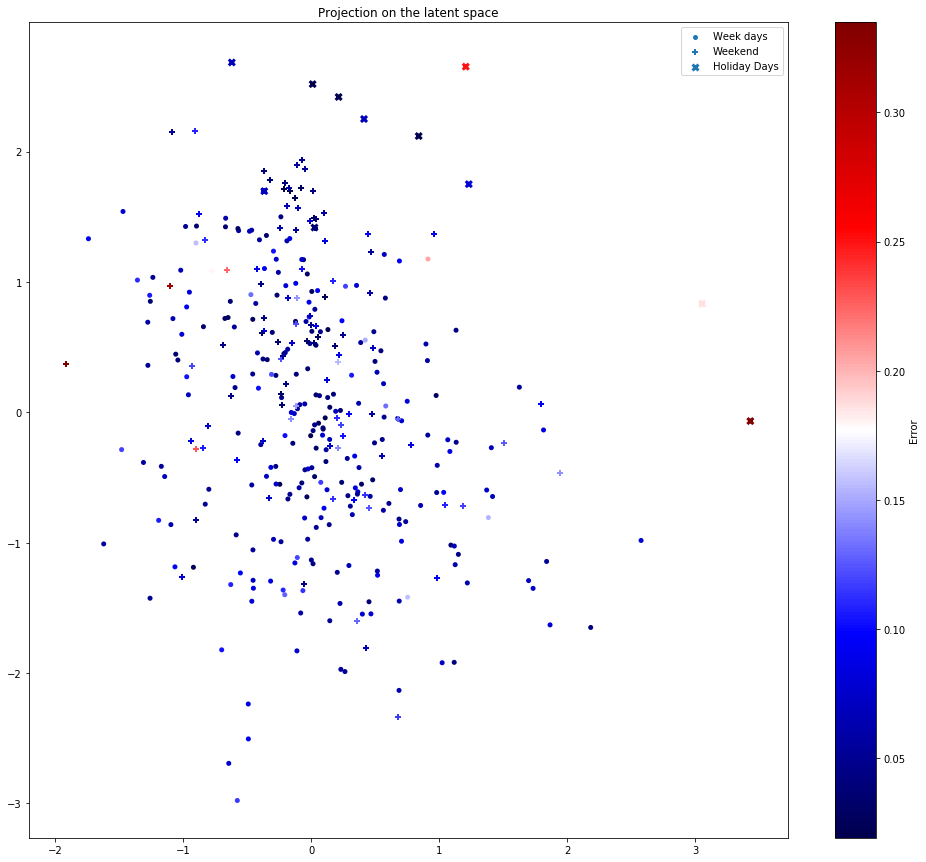

complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_true (InputLayer)             (None, 96)           0                                            
__________________________________________________________________________________________________
cond (InputLayer)               (None, 14)           0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 2), (None, 2 6856        x_true[0][0]                     
                                                                 cond[0][0]                       
__________________________________________________________________________________________________
sample_z (Lambda)               (None, 2)            0           encoder[1][0]              

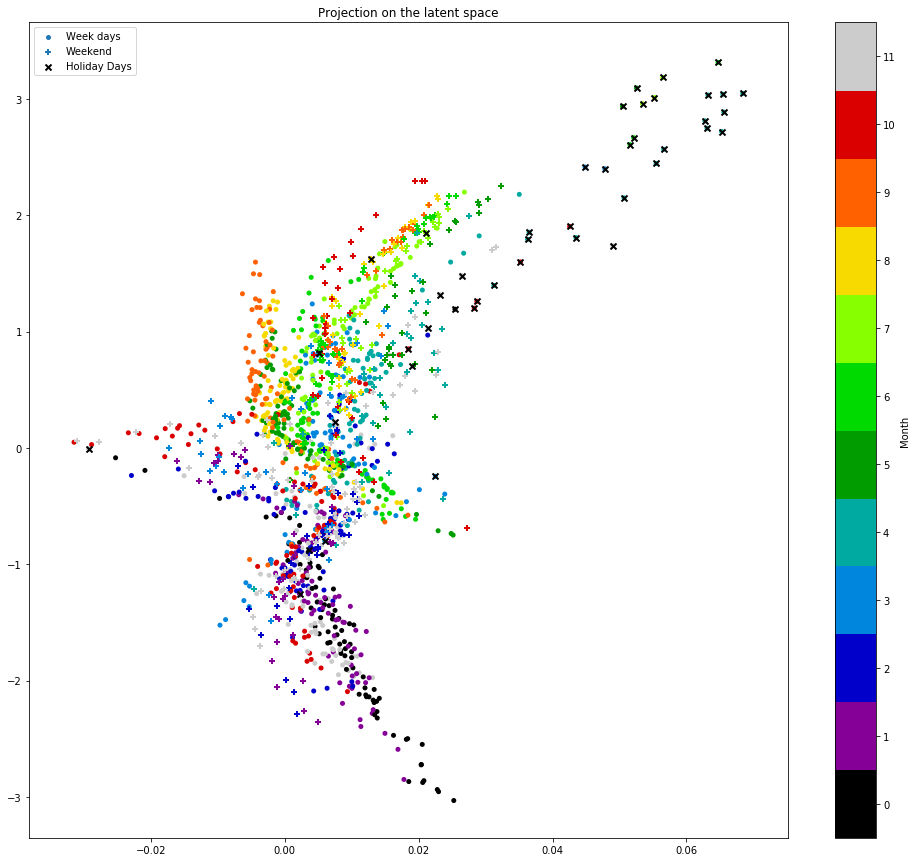

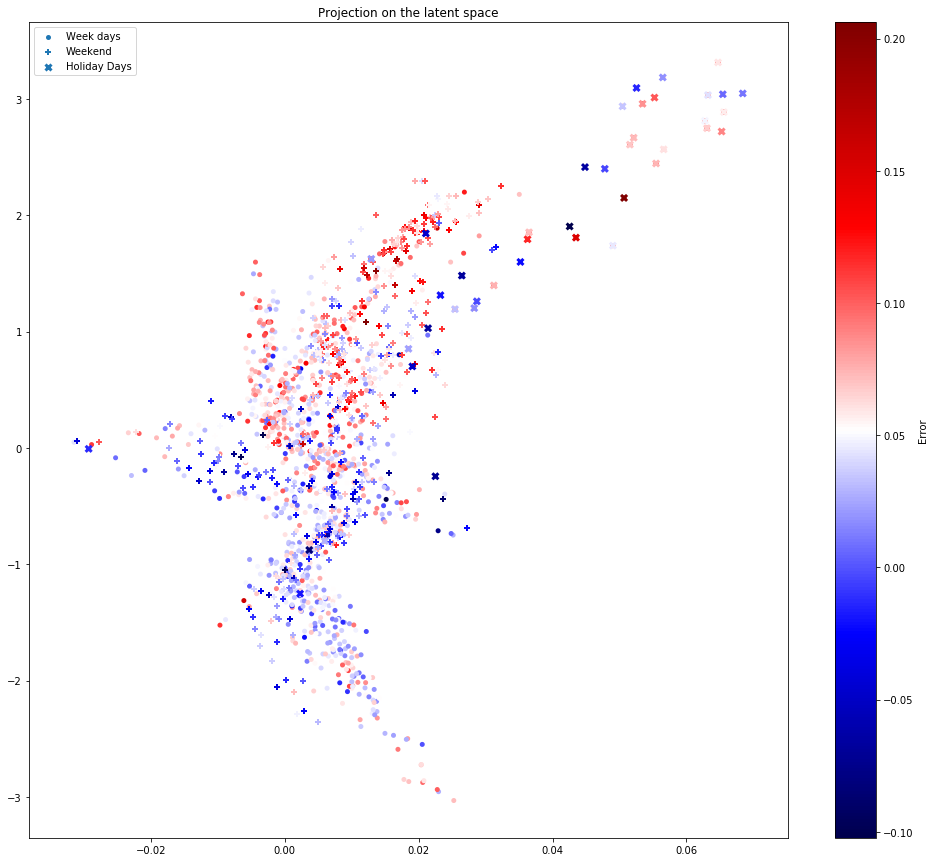

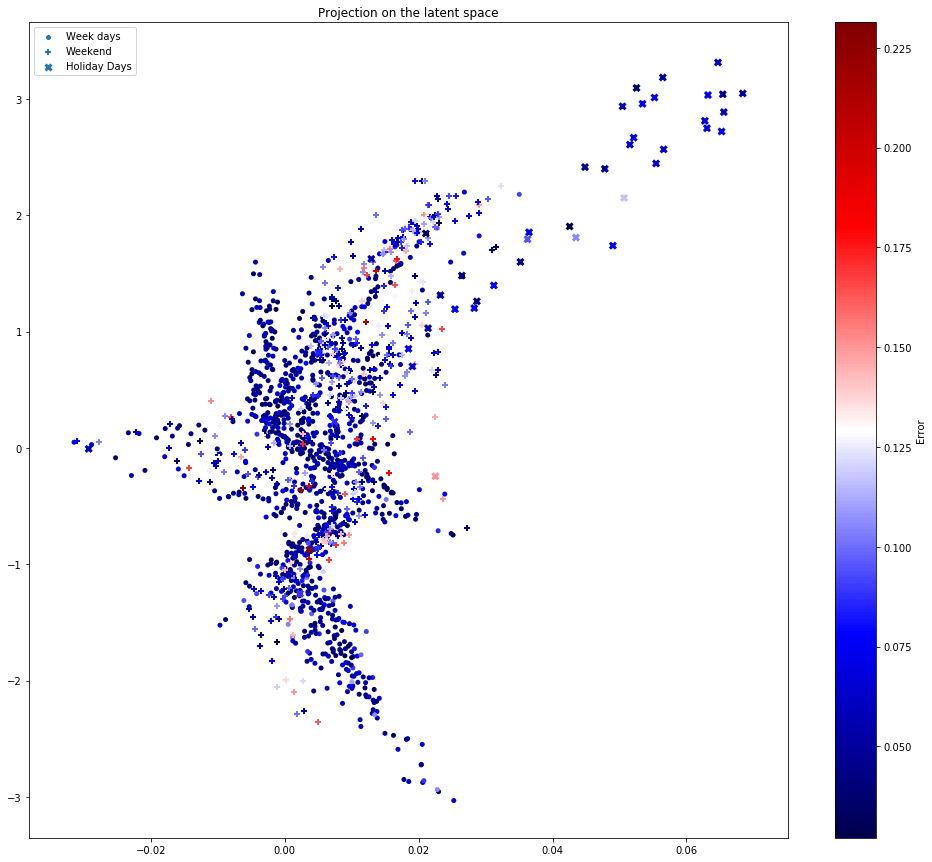

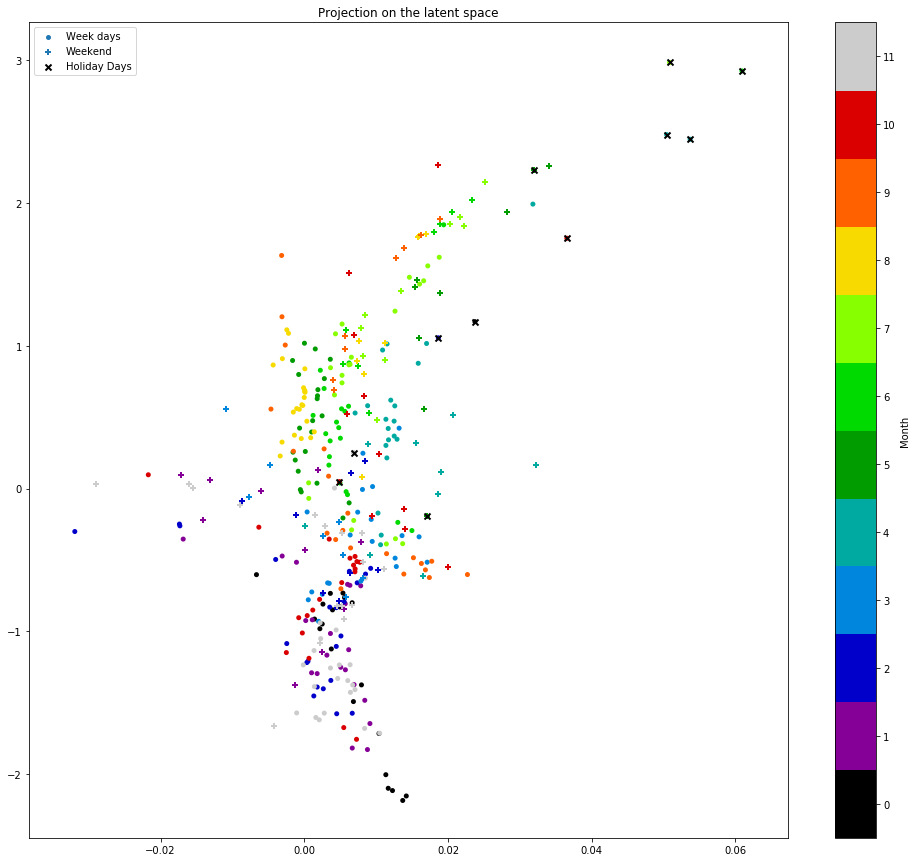

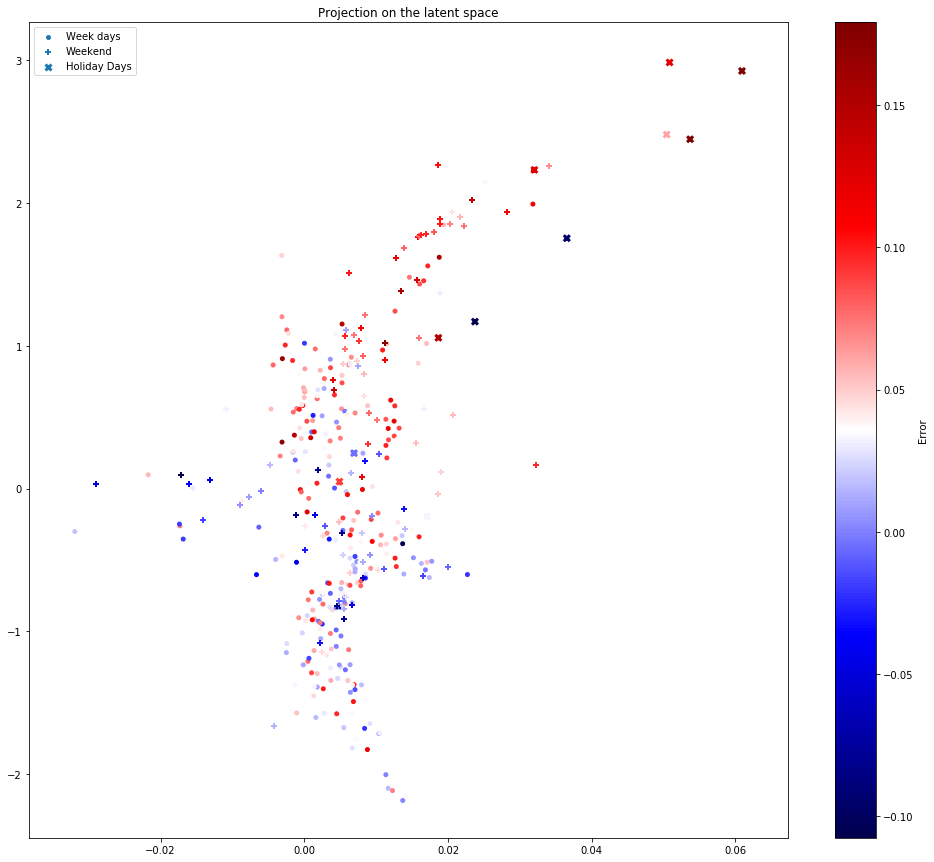

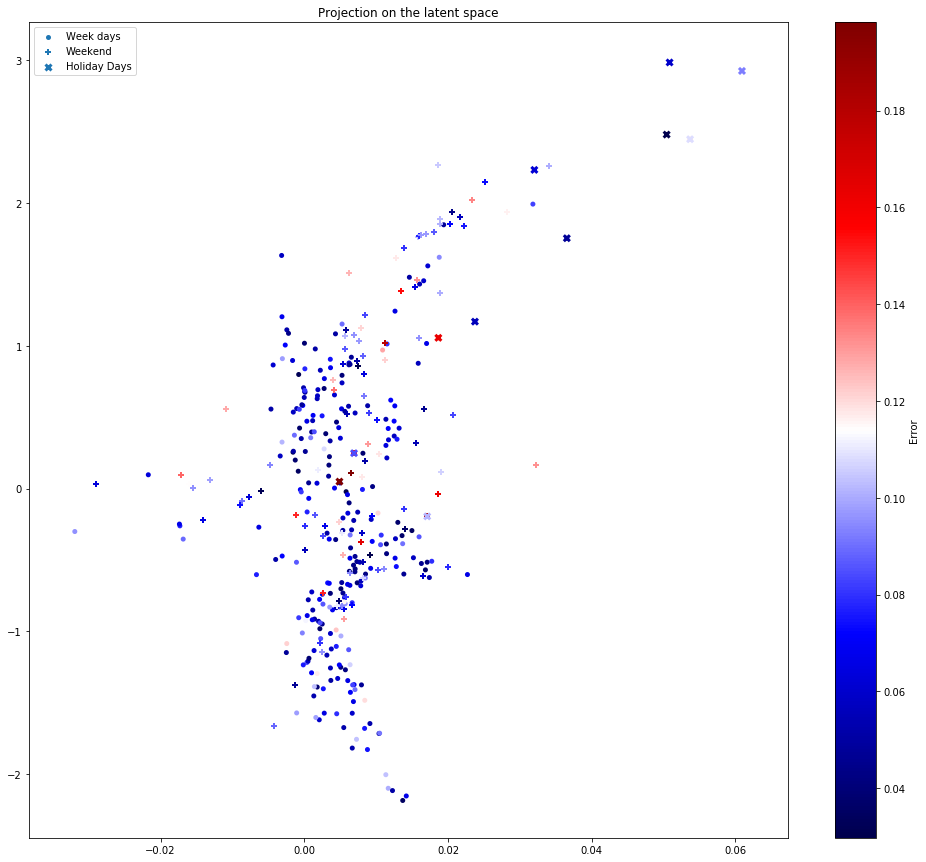

complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_true (InputLayer)             (None, 96)           0                                            
__________________________________________________________________________________________________
cond (InputLayer)               (None, 14)           0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 2), (None, 2 6856        x_true[0][0]                     
                                                                 cond[0][0]                       
__________________________________________________________________________________________________
sample_z (Lambda)               (None, 2)            0           encoder[1][0]              

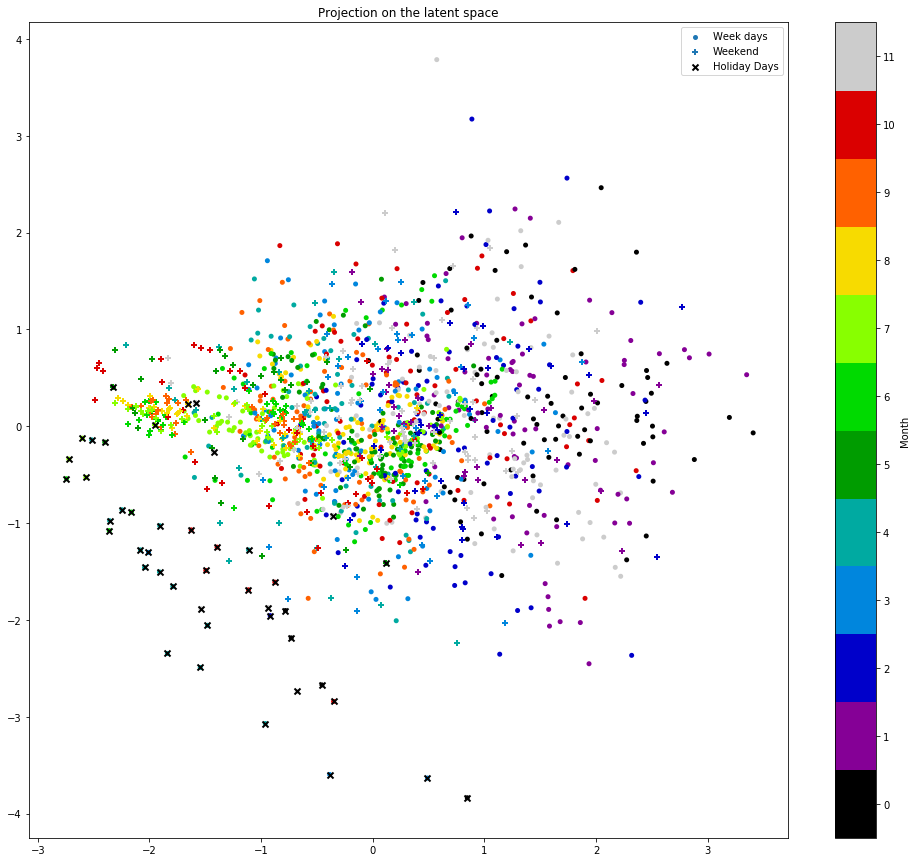

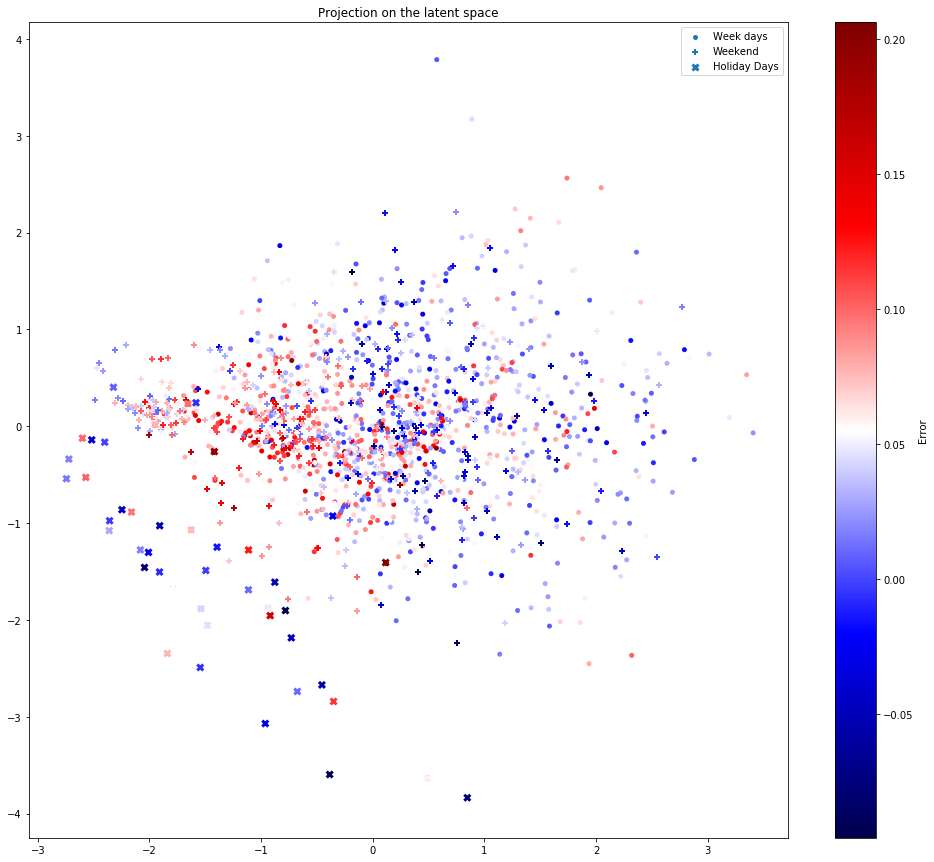

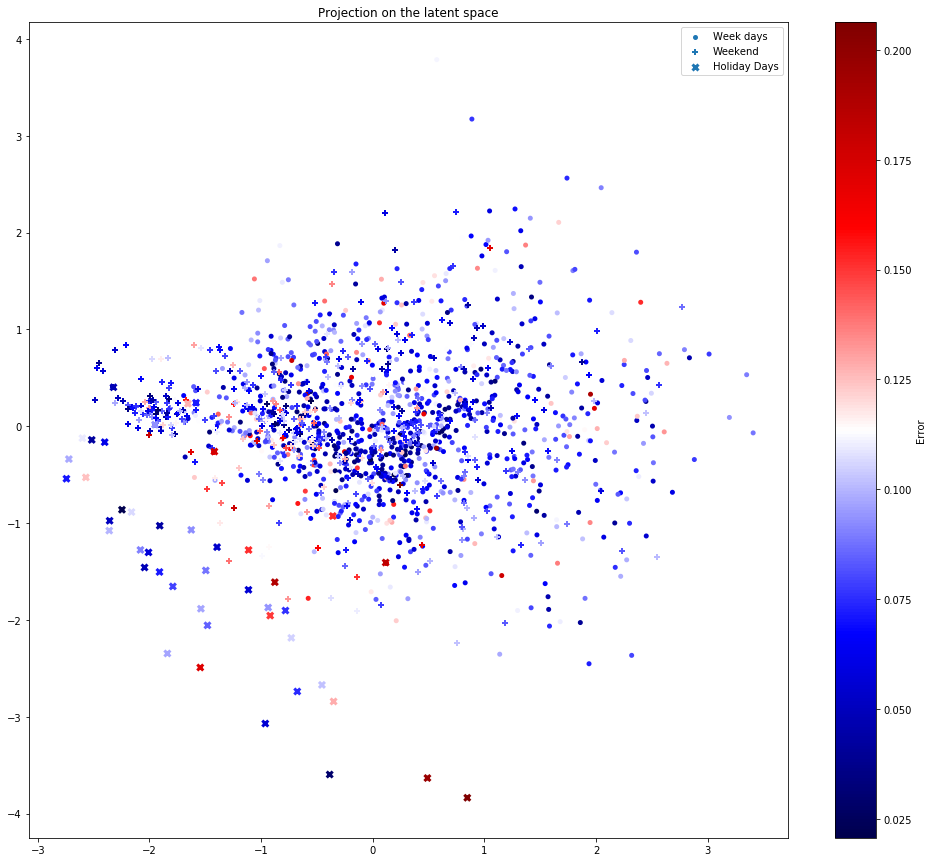

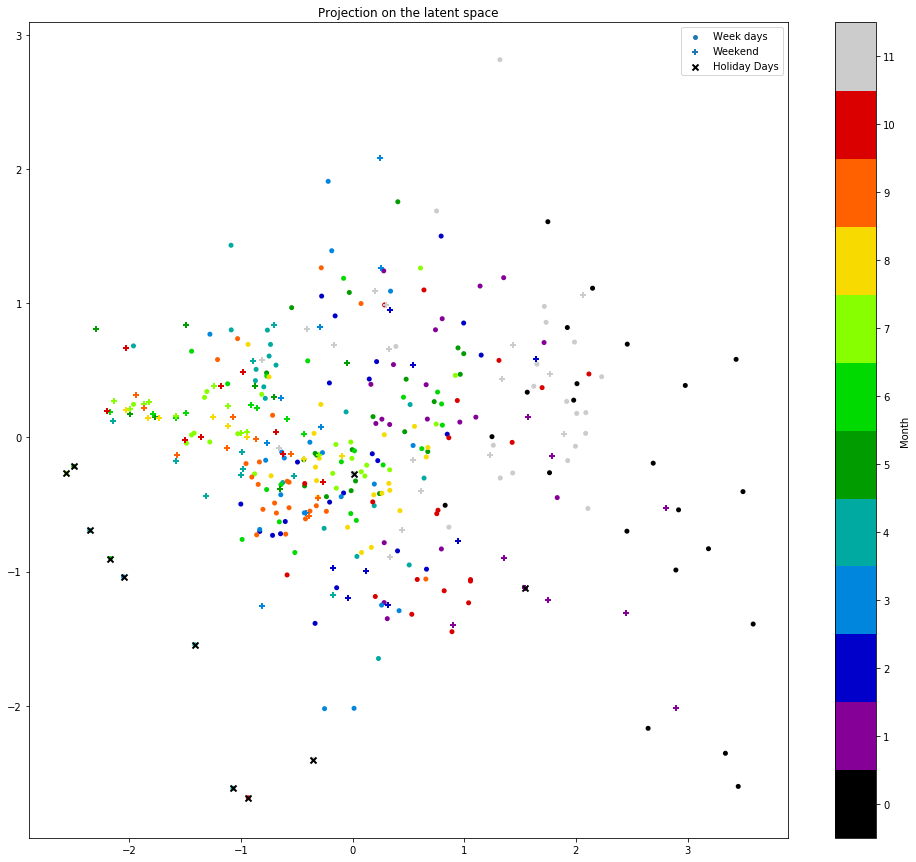

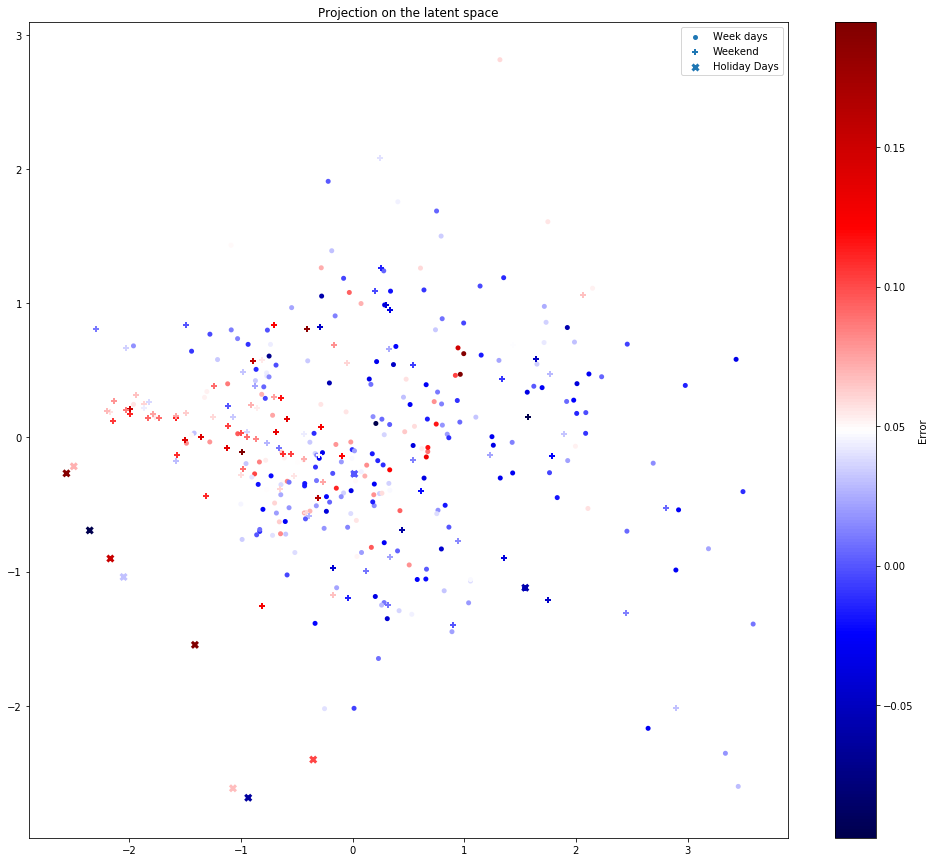

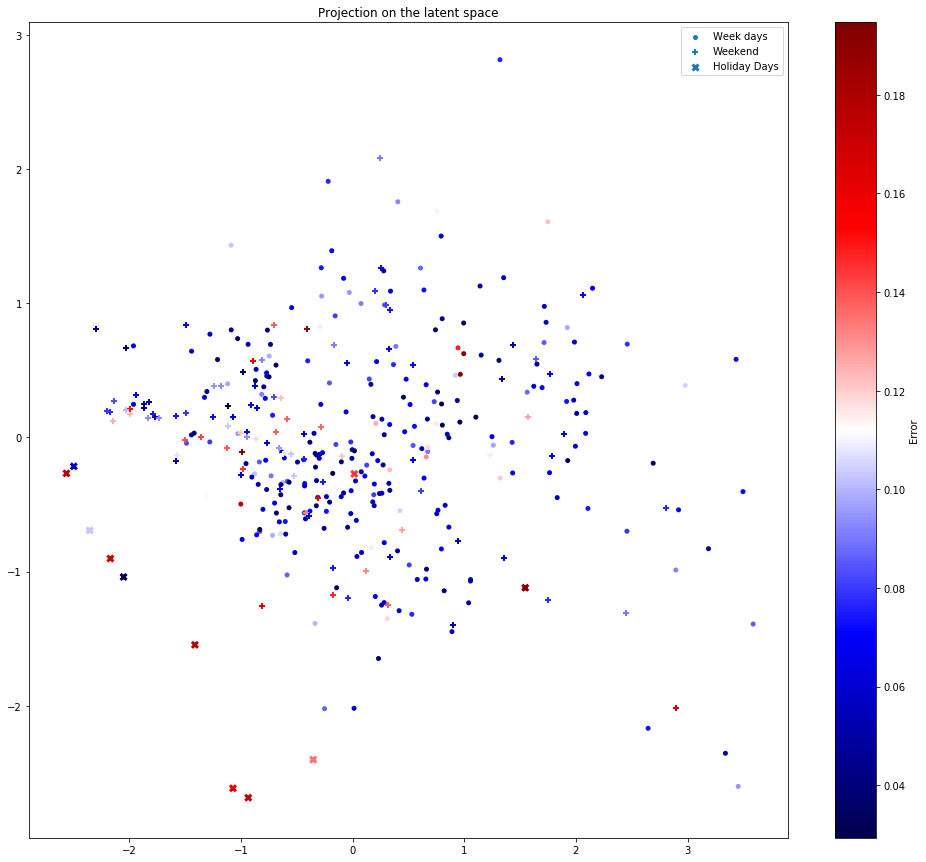

In [123]:
# Latent space study
for model_folder in list_model_folders:
    model = CVAE(cond_dim=cond_dim, e_dims=e_dims, d_dims=d_dims, 
             z_dim=z_dim, beta=beta, name=name_model, output=path_models_folder, verbose=False)
    model.load_model(os.path.join(path_models_folder,model_folder, 'models'))
    
    period = model_folder[:8]
    
    dataset = dict_datasets[period]['dataset']
    
    for type_set in ['train', 'test']:
        x_encoded = model.encoder.predict(dataset[type_set]['x'])[0]
        
        calendar_info = pd.DataFrame(dataset[type_set]['ds'])
        calendar_info['month'] = calendar_info.ds.dt.month
        calendar_info['weekday'] = calendar_info.ds.dt.weekday
        calendar_info['is_weekday'] = (calendar_info.weekday < 5).apply(lambda x:int(x))
        calendar_info = pd.merge(calendar_info, holiday_days_df[['ds', 'is_hd']], on='ds', how ='left')
        calendar_info.loc[calendar_info['is_hd'].isna(),'is_hd'] = 0
    
        # Latent space with calendar info
        name_plot = 'latent_space_{}_{}'.format(period,type_set)
        plot_latent_space_projection(x_proj=x_encoded, calendar_info=calendar_info,
                             path_folder_out=path_results, name=name_plot, 
                             pyplot=True, plotly = False)
        
        # Latent space with errors
        [x, cond] = dataset[type_set]['x']
        x_hat = model.cvae.predict(x=[x, cond])
        res_mat = (x - x_hat)
        res = res_mat.mean(axis=1)
        
        results = dict()
        results['me'] = res
        results['mae'] = np.apply_along_axis(lambda x: np.abs(x).mean(),1, res_mat)
        
        name_plot = 'latent_space_me_{}_{}'.format(period,type_set)
        error = results['me']
        pyplot_latent_space_projection_error(x_encoded, calendar_info, error, color='seismic', 
                                             path_folder_out=path_results, name=name_plot)
        
        name_plot = 'latent_space_mae_{}_{}'.format(period,type_set)
        error = results['mae']
        pyplot_latent_space_projection_error(x_encoded, calendar_info, error, color='seismic', 
                                             path_folder_out=path_results, name=name_plot)        

### Reconstruction residuals 

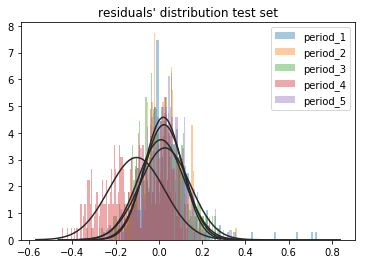

In [54]:
for model_folder in list_model_folders:
    model = CVAE(cond_dim=cond_dim, e_dims=e_dims, d_dims=d_dims, 
             z_dim=z_dim, beta=beta, name=name_model, output=path_models_folder, verbose=False)
    model.load_model(os.path.join(path_models_folder,model_folder, 'models'))
    
    period = model_folder[:8]
    
    dataset = dict_datasets[period]['dataset']
    type_set = 'test'
    
    [x, cond] = dataset[type_set]['x']
    x_hat = model.cvae.predict(x=[x, cond])
    
    res_mat = (x - x_hat)
    res = res_mat.mean(axis=1)
    
    #sn.distplot(res_mat.flatten(), kde=False, fit=stats.norm, bins=100, label=period)
    sn.distplot(res, kde=False, fit=stats.norm, bins=100, label=period)
    
    
name_plot = 'residuals_distribution_{}'.format(type_set)
plt.legend()
plt.title("residuals' distribution {} set".format(type_set))
plt.savefig(os.path.join(path_results, name_plot))

### AED

In [78]:
mode = 2

In [79]:
# get prediction results
prediction_results = {}

for model_folder in list_model_folders:
    # load model
    model = CVAE(cond_dim=cond_dim, e_dims=e_dims, d_dims=d_dims, 
             z_dim=z_dim, beta=beta, name=name_model, output=path_models_folder, verbose=False)
    model.load_model(os.path.join(path_models_folder,model_folder, 'models'))
    
    # get dataset info
    period = model_folder[:8]
    dataset = dict_datasets[period]['dataset']
    [x, cond] = dataset['test']['x']
    y = dataset['test']['y']
    ds = dataset['test']['ds']
    
    # get predictions and 
    x_hat = model.cvae.predict(x=[x, cond])
    
    prediction = x_hat.flatten()
    residuals = (x-x_hat).flatten()
    
    date_start = ds[0]
    date_end = ds.iloc[-1] + pd.DateOffset(hour=23) + pd.DateOffset(minute=45)
    ds_flatten = pd.date_range(date_start, date_end, freq='15min')
    
    assert ds_flatten.shape == residuals.shape

    # results
    prediction_df = pd.DataFrame({'ds': ds_flatten, 'prediction': prediction})
    residuals_df = pd.DataFrame({'ds': ds_flatten, 'residuals': residuals})
    detector_df = get_atypical_score(residuals_df, mode=mode)
    
    prediction_results[period] = {'detector_df': detector_df, 'prediction_df': prediction_df}

In [80]:
# get atypical events info
threshold = 0.98
aed_results, ael_full_model = get_aed_results(prediction_results, threshold)

In [81]:
# getting complete dataframe
atypical_full_df, prediction_full_df = get_complete_df(prediction_results, aed_results)

In [82]:
# get infos about top atypical days
pd.options.display.max_rows = 200
atypical_new_df = sort_atypical_events(atypical_full_df, ael_reference)

In [91]:
df_plot = atypical_new_df.head(200).copy()
df_plot['ind'] = np.array(range(200))

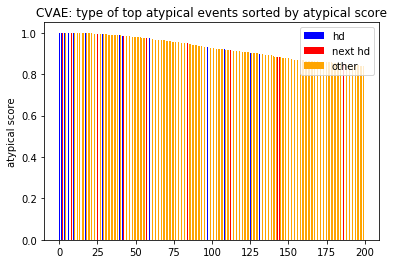

In [92]:
type_model = 'CVAE'

width = 0.5
idx = 0
epsilon = 0

mask = df_plot['type_event']==1
df_plot_mask = df_plot[mask]

ind = df_plot_mask['ind']
plt.bar(ind, df_plot_mask['a_score'], width, label='hd', color = 'blue',align = 'edge')

mask = df_plot['type_event']==-1
df_plot_mask = df_plot[mask]

ind = df_plot_mask['ind']
plt.bar(ind, df_plot_mask['a_score'], width, label='next hd', color = 'red')

mask = df_plot['type_event'].isna()
df_plot_mask = df_plot[mask]

ind = df_plot_mask['ind']
plt.bar(ind, df_plot_mask['a_score'], width, label='other', color = 'orange')

plt.legend()
plt.ylabel('atypical score')
plt.title('{}: type of top atypical events sorted by atypical score'.format(type_model))

path_save = os.path.join(path_main_folder, 'out', 'figures')
name_fig = '{}_top_atypical_events_mode-{}'.format(type_model, mode)
#plt.savefig(os.path.join(path_results, name_fig + '.png'))
#plt.savefig(os.path.join(path_results, name_fig + '.eps'))